In [1]:
import os
import numpy as np
import pandas as pd
import torch
import rdkit
from torch_geometric.datasets import MoleculeNet
from gnn import GIN_mol, GAT_mol, Transform_mol, SAGE_mol
from visualization import draw_molecule
from training import train_graph_classifier, stratified_split, sample_data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from utils.create_dataset import MolDataset
from sklearn.preprocessing import OneHotEncoder
from inference import get_graphClass_results


In [2]:
# Get data
molhiv_dataset = MoleculeNet(root="../data/molecule_data", name = "HIV")
msi_dataset = MolDataset(root="../data/msi_drugs/") 

In [3]:
# Split into training, testing, and validation.
train_data, val_data, test_data = stratified_split(molhiv_dataset, 0.8, 0.1, 0.1)
total_data, _, _ = stratified_split(molhiv_dataset, 1.0, 0.0, 0.0)
train_data_down = sample_data(train_data)
total_data_down = sample_data(total_data)

In [4]:
# Perform some intitial EDA.

print()
print(f'Dataset: {molhiv_dataset}:')
print('====================')
print(f'Number of graphs: {len(molhiv_dataset)}')
print(f'Number of features: {molhiv_dataset.num_features}')
print(f'Number of classes: {molhiv_dataset.num_classes}')

data = molhiv_dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# Draw the first molecule in the data set.

draw_molecule(molhiv_dataset[0].smiles)


Dataset: HIV(41127):
Number of graphs: 41127
Number of features: 9
Number of classes: 2

Data(x=[19, 9], edge_index=[2, 40], edge_attr=[40, 3], smiles='CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2', y=[1, 1])
Number of nodes: 19
Number of edges: 40
Average node degree: 2.11
Has isolated nodes: False
Has self-loops: False
Is undirected: True


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
# Create minibatches.
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)
total_loader = DataLoader(total_data_down, batch_size=128, shuffle=True)
production_loader = DataLoader(msi_dataset, batch_size=128, shuffle=False)


In [6]:
# Set the device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [7]:
# Insantiate model
model = GAT_mol(hidden_channels=128, num_classes=1).to(device)
#model = SAGE_mol(hidden_channels=128, num_classes=1).to(device)
#model = Transform_mol(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-45)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
for epoch in range(1, 100+1):
    loss, auc, model = train_graph_classifier(model, train_loader, criterion, optimizer, device, train=True)
    val_loss, val_auc, model= train_graph_classifier(model, val_loader, criterion, optimizer, device, train=False)
    
    print(f"Epoch: {epoch:03d}")
    print(f"Train loss: {loss:<15.4f}\t|  Train auc: {auc:>15.4f}")
    print(f"Val loss: {val_loss:<15.4f}\t| Val auc: {val_auc:>15.4f}")
    

100%|██████████| 33/33 [00:00<00:00, 64.82it/s]


Epoch: 001
Train loss: 0.2140         	|  Train auc:          0.6043
Val loss: 0.1581         	| Val auc:          0.6127


100%|██████████| 33/33 [00:00<00:00, 64.84it/s]


Epoch: 002
Train loss: 0.1504         	|  Train auc:          0.6378
Val loss: 0.1640         	| Val auc:          0.5907


100%|██████████| 33/33 [00:00<00:00, 60.97it/s]


Epoch: 003
Train loss: 0.1474         	|  Train auc:          0.6374
Val loss: 0.2795         	| Val auc:          0.6121


100%|██████████| 33/33 [00:00<00:00, 64.15it/s]


Epoch: 004
Train loss: 0.1459         	|  Train auc:          0.6471
Val loss: 0.1568         	| Val auc:          0.6580


100%|██████████| 33/33 [00:01<00:00, 28.71it/s]


Epoch: 005
Train loss: 0.1442         	|  Train auc:          0.6575
Val loss: 0.1550         	| Val auc:          0.6164


100%|██████████| 33/33 [00:00<00:00, 63.20it/s]


Epoch: 006
Train loss: 0.1446         	|  Train auc:          0.6663
Val loss: 0.1478         	| Val auc:          0.6632


100%|██████████| 33/33 [00:00<00:00, 64.28it/s]


Epoch: 007
Train loss: 0.1419         	|  Train auc:          0.6718
Val loss: 0.1444         	| Val auc:          0.6610


100%|██████████| 33/33 [00:00<00:00, 64.85it/s]


Epoch: 008
Train loss: 0.1413         	|  Train auc:          0.6876
Val loss: 0.2512         	| Val auc:          0.7083


100%|██████████| 33/33 [00:00<00:00, 64.81it/s]


Epoch: 009
Train loss: 0.1458         	|  Train auc:          0.6585
Val loss: 0.1673         	| Val auc:          0.7026


100%|██████████| 33/33 [00:00<00:00, 65.60it/s]


Epoch: 010
Train loss: 0.1413         	|  Train auc:          0.6955
Val loss: 0.1467         	| Val auc:          0.7223


100%|██████████| 33/33 [00:00<00:00, 65.61it/s]


Epoch: 011
Train loss: 0.1388         	|  Train auc:          0.6993
Val loss: 0.1482         	| Val auc:          0.7281


100%|██████████| 33/33 [00:00<00:00, 65.03it/s]


Epoch: 012
Train loss: 0.1375         	|  Train auc:          0.7225
Val loss: 0.1430         	| Val auc:          0.7072


100%|██████████| 33/33 [00:00<00:00, 65.34it/s]


Epoch: 013
Train loss: 0.1422         	|  Train auc:          0.6816
Val loss: 1.9710         	| Val auc:          0.6869


100%|██████████| 33/33 [00:00<00:00, 65.13it/s]


Epoch: 014
Train loss: 0.1386         	|  Train auc:          0.7036
Val loss: 0.2931         	| Val auc:          0.6691


100%|██████████| 33/33 [00:00<00:00, 65.37it/s]


Epoch: 015
Train loss: 0.1360         	|  Train auc:          0.7280
Val loss: 0.1833         	| Val auc:          0.7314


100%|██████████| 33/33 [00:00<00:00, 64.80it/s]


Epoch: 016
Train loss: 0.1395         	|  Train auc:          0.6898
Val loss: 0.7701         	| Val auc:          0.6794


100%|██████████| 33/33 [00:00<00:00, 64.63it/s]


Epoch: 017
Train loss: 0.1393         	|  Train auc:          0.6957
Val loss: 0.1417         	| Val auc:          0.7003


100%|██████████| 33/33 [00:00<00:00, 64.67it/s]


Epoch: 018
Train loss: 0.1360         	|  Train auc:          0.7173
Val loss: 0.2563         	| Val auc:          0.7116


100%|██████████| 33/33 [00:00<00:00, 62.98it/s]


Epoch: 019
Train loss: 0.1342         	|  Train auc:          0.7209
Val loss: 0.1356         	| Val auc:          0.7650


100%|██████████| 33/33 [00:00<00:00, 65.26it/s]


Epoch: 020
Train loss: 0.1315         	|  Train auc:          0.7354
Val loss: 0.1849         	| Val auc:          0.7619


100%|██████████| 33/33 [00:00<00:00, 65.05it/s]


Epoch: 021
Train loss: 0.1312         	|  Train auc:          0.7348
Val loss: 0.1729         	| Val auc:          0.7571


100%|██████████| 33/33 [00:00<00:00, 65.49it/s]


Epoch: 022
Train loss: 0.1301         	|  Train auc:          0.7371
Val loss: 0.1323         	| Val auc:          0.7781


100%|██████████| 33/33 [00:00<00:00, 65.04it/s]


Epoch: 023
Train loss: 0.1281         	|  Train auc:          0.7543
Val loss: 0.1331         	| Val auc:          0.7235


100%|██████████| 33/33 [00:00<00:00, 65.25it/s]


Epoch: 024
Train loss: 0.1293         	|  Train auc:          0.7517
Val loss: 0.1370         	| Val auc:          0.7533


100%|██████████| 33/33 [00:00<00:00, 63.42it/s]


Epoch: 025
Train loss: 0.1274         	|  Train auc:          0.7460
Val loss: 0.1412         	| Val auc:          0.7346


100%|██████████| 33/33 [00:00<00:00, 64.73it/s]


Epoch: 026
Train loss: 0.1268         	|  Train auc:          0.7542
Val loss: 8.5794         	| Val auc:          0.7169


100%|██████████| 33/33 [00:00<00:00, 65.16it/s]


Epoch: 027
Train loss: 0.1359         	|  Train auc:          0.7189
Val loss: 1.5887         	| Val auc:          0.7205


100%|██████████| 33/33 [00:00<00:00, 64.86it/s]


Epoch: 028
Train loss: 0.1294         	|  Train auc:          0.7481
Val loss: 0.1243         	| Val auc:          0.7861


100%|██████████| 33/33 [00:00<00:00, 65.21it/s]


Epoch: 029
Train loss: 0.1329         	|  Train auc:          0.7281
Val loss: 0.1268         	| Val auc:          0.7787


100%|██████████| 33/33 [00:00<00:00, 64.46it/s]


Epoch: 030
Train loss: 0.1272         	|  Train auc:          0.7602
Val loss: 0.1483         	| Val auc:          0.7456


100%|██████████| 33/33 [00:00<00:00, 62.33it/s]


Epoch: 031
Train loss: 0.1310         	|  Train auc:          0.7501
Val loss: 1.8227         	| Val auc:          0.7658


100%|██████████| 33/33 [00:00<00:00, 63.99it/s]


Epoch: 032
Train loss: 0.1257         	|  Train auc:          0.7794
Val loss: 0.1731         	| Val auc:          0.7424


100%|██████████| 33/33 [00:00<00:00, 65.08it/s]


Epoch: 033
Train loss: 0.1231         	|  Train auc:          0.7825
Val loss: 0.1267         	| Val auc:          0.7688


100%|██████████| 33/33 [00:00<00:00, 65.12it/s]


Epoch: 034
Train loss: 0.1229         	|  Train auc:          0.7721
Val loss: 0.1350         	| Val auc:          0.8271


100%|██████████| 33/33 [00:00<00:00, 63.85it/s]


Epoch: 035
Train loss: 0.1254         	|  Train auc:          0.7642
Val loss: 0.1394         	| Val auc:          0.7822


100%|██████████| 33/33 [00:00<00:00, 64.23it/s]


Epoch: 036
Train loss: 0.1230         	|  Train auc:          0.7822
Val loss: 0.1224         	| Val auc:          0.7826


100%|██████████| 33/33 [00:00<00:00, 64.94it/s]


Epoch: 037
Train loss: 0.1210         	|  Train auc:          0.7777
Val loss: 0.1243         	| Val auc:          0.8104


100%|██████████| 33/33 [00:00<00:00, 65.18it/s]


Epoch: 038
Train loss: 0.1236         	|  Train auc:          0.7776
Val loss: 1.1047         	| Val auc:          0.7814


100%|██████████| 33/33 [00:00<00:00, 64.74it/s]


Epoch: 039
Train loss: 0.1221         	|  Train auc:          0.7711
Val loss: 1.0729         	| Val auc:          0.7986


100%|██████████| 33/33 [00:00<00:00, 65.29it/s]


Epoch: 040
Train loss: 0.1246         	|  Train auc:          0.7767
Val loss: 0.2783         	| Val auc:          0.7505


100%|██████████| 33/33 [00:00<00:00, 65.08it/s]


Epoch: 041
Train loss: 0.1320         	|  Train auc:          0.7375
Val loss: 0.1270         	| Val auc:          0.7704


100%|██████████| 33/33 [00:00<00:00, 64.20it/s]


Epoch: 042
Train loss: 0.1239         	|  Train auc:          0.7809
Val loss: 0.1414         	| Val auc:          0.7552


100%|██████████| 33/33 [00:00<00:00, 63.54it/s]


Epoch: 043
Train loss: 0.1209         	|  Train auc:          0.7911
Val loss: 0.1868         	| Val auc:          0.7398


100%|██████████| 33/33 [00:00<00:00, 65.44it/s]


Epoch: 044
Train loss: 0.1206         	|  Train auc:          0.7897
Val loss: 0.1738         	| Val auc:          0.7831


100%|██████████| 33/33 [00:00<00:00, 64.91it/s]


Epoch: 045
Train loss: 0.1253         	|  Train auc:          0.7768
Val loss: 0.1422         	| Val auc:          0.7402


100%|██████████| 33/33 [00:00<00:00, 64.95it/s]


Epoch: 046
Train loss: 0.1197         	|  Train auc:          0.7995
Val loss: 0.1553         	| Val auc:          0.7767


100%|██████████| 33/33 [00:00<00:00, 64.16it/s]


Epoch: 047
Train loss: 0.1207         	|  Train auc:          0.7998
Val loss: 0.1630         	| Val auc:          0.8048


100%|██████████| 33/33 [00:00<00:00, 63.45it/s]


Epoch: 048
Train loss: 0.1201         	|  Train auc:          0.7897
Val loss: 0.1204         	| Val auc:          0.7948


100%|██████████| 33/33 [00:00<00:00, 63.58it/s]


Epoch: 049
Train loss: 0.1188         	|  Train auc:          0.8081
Val loss: 0.1295         	| Val auc:          0.7430


100%|██████████| 33/33 [00:00<00:00, 64.78it/s]


Epoch: 050
Train loss: 0.1180         	|  Train auc:          0.8068
Val loss: 0.1264         	| Val auc:          0.7982


100%|██████████| 33/33 [00:00<00:00, 65.89it/s]


Epoch: 051
Train loss: 0.1174         	|  Train auc:          0.8024
Val loss: 0.1381         	| Val auc:          0.7945


100%|██████████| 33/33 [00:00<00:00, 63.82it/s]


Epoch: 052
Train loss: 0.1179         	|  Train auc:          0.7974
Val loss: 0.1276         	| Val auc:          0.7775


100%|██████████| 33/33 [00:00<00:00, 65.48it/s]


Epoch: 053
Train loss: 0.1195         	|  Train auc:          0.8053
Val loss: 0.1301         	| Val auc:          0.7481


100%|██████████| 33/33 [00:00<00:00, 63.81it/s]


Epoch: 054
Train loss: 0.1183         	|  Train auc:          0.7953
Val loss: 0.1705         	| Val auc:          0.7724


100%|██████████| 33/33 [00:00<00:00, 65.24it/s]


Epoch: 055
Train loss: 0.1179         	|  Train auc:          0.7991
Val loss: 0.1828         	| Val auc:          0.7918


100%|██████████| 33/33 [00:00<00:00, 65.30it/s]


Epoch: 056
Train loss: 0.1195         	|  Train auc:          0.7931
Val loss: 0.4504         	| Val auc:          0.7735


100%|██████████| 33/33 [00:00<00:00, 65.32it/s]


Epoch: 057
Train loss: 0.1189         	|  Train auc:          0.8016
Val loss: 0.1399         	| Val auc:          0.7934


100%|██████████| 33/33 [00:00<00:00, 65.59it/s]


Epoch: 058
Train loss: 0.1167         	|  Train auc:          0.7927
Val loss: 0.1211         	| Val auc:          0.8043


100%|██████████| 33/33 [00:00<00:00, 65.88it/s]


Epoch: 059
Train loss: 0.1180         	|  Train auc:          0.8050
Val loss: 0.1428         	| Val auc:          0.8060


100%|██████████| 33/33 [00:00<00:00, 59.91it/s]


Epoch: 060
Train loss: 0.1217         	|  Train auc:          0.7971
Val loss: 0.1701         	| Val auc:          0.7788


100%|██████████| 33/33 [00:00<00:00, 65.05it/s]


Epoch: 061
Train loss: 0.1213         	|  Train auc:          0.8011
Val loss: 0.2413         	| Val auc:          0.7716


100%|██████████| 33/33 [00:00<00:00, 65.81it/s]


Epoch: 062
Train loss: 0.1209         	|  Train auc:          0.8024
Val loss: 0.1306         	| Val auc:          0.8005


100%|██████████| 33/33 [00:00<00:00, 65.71it/s]


Epoch: 063
Train loss: 0.1223         	|  Train auc:          0.7884
Val loss: 0.1618         	| Val auc:          0.8148


100%|██████████| 33/33 [00:00<00:00, 65.69it/s]


Epoch: 064
Train loss: 0.1194         	|  Train auc:          0.7912
Val loss: 0.1551         	| Val auc:          0.7899


100%|██████████| 33/33 [00:00<00:00, 65.76it/s]


Epoch: 065
Train loss: 0.1260         	|  Train auc:          0.7666
Val loss: 0.1226         	| Val auc:          0.7998


100%|██████████| 33/33 [00:00<00:00, 65.18it/s]


Epoch: 066
Train loss: 0.1178         	|  Train auc:          0.7969
Val loss: 0.1183         	| Val auc:          0.8219


100%|██████████| 33/33 [00:00<00:00, 65.19it/s]


Epoch: 067
Train loss: 0.1158         	|  Train auc:          0.8021
Val loss: 0.1248         	| Val auc:          0.7888


100%|██████████| 33/33 [00:00<00:00, 64.13it/s]


Epoch: 068
Train loss: 0.1165         	|  Train auc:          0.8018
Val loss: 0.1220         	| Val auc:          0.7603


100%|██████████| 33/33 [00:00<00:00, 62.14it/s]


Epoch: 069
Train loss: 0.1188         	|  Train auc:          0.8040
Val loss: 0.1654         	| Val auc:          0.7642


100%|██████████| 33/33 [00:00<00:00, 65.86it/s]


Epoch: 070
Train loss: 0.1174         	|  Train auc:          0.8012
Val loss: 0.1308         	| Val auc:          0.7903


100%|██████████| 33/33 [00:00<00:00, 64.05it/s]


Epoch: 071
Train loss: 0.1154         	|  Train auc:          0.8046
Val loss: 0.1651         	| Val auc:          0.8119


100%|██████████| 33/33 [00:00<00:00, 65.33it/s]


Epoch: 072
Train loss: 0.1148         	|  Train auc:          0.7977
Val loss: 0.3790         	| Val auc:          0.8196


100%|██████████| 33/33 [00:00<00:00, 65.93it/s]


Epoch: 073
Train loss: 0.1138         	|  Train auc:          0.8287
Val loss: 0.1277         	| Val auc:          0.7751


100%|██████████| 33/33 [00:00<00:00, 65.95it/s]


Epoch: 074
Train loss: 0.1176         	|  Train auc:          0.8019
Val loss: 0.1293         	| Val auc:          0.7698


100%|██████████| 33/33 [00:00<00:00, 66.39it/s]


Epoch: 075
Train loss: 0.1152         	|  Train auc:          0.8195
Val loss: 0.1175         	| Val auc:          0.8324


100%|██████████| 33/33 [00:00<00:00, 66.50it/s]


Epoch: 076
Train loss: 0.1149         	|  Train auc:          0.8102
Val loss: 0.1291         	| Val auc:          0.7883


100%|██████████| 33/33 [00:00<00:00, 63.66it/s]


Epoch: 077
Train loss: 0.1136         	|  Train auc:          0.8230
Val loss: 0.1799         	| Val auc:          0.7716


100%|██████████| 33/33 [00:00<00:00, 66.16it/s]


Epoch: 078
Train loss: 0.1269         	|  Train auc:          0.7708
Val loss: 0.1255         	| Val auc:          0.7673


100%|██████████| 33/33 [00:00<00:00, 66.02it/s]


Epoch: 079
Train loss: 0.1215         	|  Train auc:          0.7842
Val loss: 0.1290         	| Val auc:          0.7653


100%|██████████| 33/33 [00:00<00:00, 63.89it/s]


Epoch: 080
Train loss: 0.1176         	|  Train auc:          0.8153
Val loss: 0.1926         	| Val auc:          0.7843


100%|██████████| 33/33 [00:00<00:00, 65.61it/s]


Epoch: 081
Train loss: 0.1159         	|  Train auc:          0.8039
Val loss: 0.1359         	| Val auc:          0.7949


100%|██████████| 33/33 [00:00<00:00, 63.24it/s]


Epoch: 082
Train loss: 0.1157         	|  Train auc:          0.8143
Val loss: 0.1216         	| Val auc:          0.7708


100%|██████████| 33/33 [00:00<00:00, 61.54it/s]


Epoch: 083
Train loss: 0.1134         	|  Train auc:          0.8168
Val loss: 0.1505         	| Val auc:          0.8081


100%|██████████| 33/33 [00:00<00:00, 66.18it/s]


Epoch: 084
Train loss: 0.1143         	|  Train auc:          0.8096
Val loss: 0.1185         	| Val auc:          0.7549


100%|██████████| 33/33 [00:00<00:00, 65.62it/s]


Epoch: 085
Train loss: 0.1131         	|  Train auc:          0.8239
Val loss: 0.2634         	| Val auc:          0.7932


100%|██████████| 33/33 [00:00<00:00, 66.46it/s]


Epoch: 086
Train loss: 0.1136         	|  Train auc:          0.8236
Val loss: 0.1642         	| Val auc:          0.8155


100%|██████████| 33/33 [00:00<00:00, 65.58it/s]


Epoch: 087
Train loss: 0.1130         	|  Train auc:          0.8228
Val loss: 0.1820         	| Val auc:          0.7429


100%|██████████| 33/33 [00:00<00:00, 66.55it/s]


Epoch: 088
Train loss: 0.1137         	|  Train auc:          0.8275
Val loss: 0.1477         	| Val auc:          0.7926


100%|██████████| 33/33 [00:00<00:00, 65.69it/s]


Epoch: 089
Train loss: 0.1120         	|  Train auc:          0.8260
Val loss: 0.1935         	| Val auc:          0.7492


100%|██████████| 33/33 [00:00<00:00, 66.01it/s]


Epoch: 090
Train loss: 0.1157         	|  Train auc:          0.8089
Val loss: 0.1197         	| Val auc:          0.8170


100%|██████████| 33/33 [00:00<00:00, 64.55it/s]


Epoch: 091
Train loss: 0.1130         	|  Train auc:          0.8091
Val loss: 0.4156         	| Val auc:          0.7724


100%|██████████| 33/33 [00:00<00:00, 65.55it/s]


Epoch: 092
Train loss: 0.1153         	|  Train auc:          0.8159
Val loss: 0.1203         	| Val auc:          0.7660


100%|██████████| 33/33 [00:00<00:00, 64.60it/s]


Epoch: 093
Train loss: 0.1120         	|  Train auc:          0.8235
Val loss: 0.2968         	| Val auc:          0.7962


100%|██████████| 33/33 [00:00<00:00, 66.94it/s]


Epoch: 094
Train loss: 0.1355         	|  Train auc:          0.7303
Val loss: 4.8170         	| Val auc:          0.7087


100%|██████████| 33/33 [00:00<00:00, 66.10it/s]


Epoch: 095
Train loss: 0.1342         	|  Train auc:          0.7310
Val loss: 0.1316         	| Val auc:          0.7329


100%|██████████| 33/33 [00:00<00:00, 64.70it/s]


Epoch: 096
Train loss: 0.1298         	|  Train auc:          0.7457
Val loss: 0.1297         	| Val auc:          0.7696


100%|██████████| 33/33 [00:00<00:00, 66.23it/s]


Epoch: 097
Train loss: 0.1275         	|  Train auc:          0.7564
Val loss: 0.1352         	| Val auc:          0.7880


100%|██████████| 33/33 [00:00<00:00, 66.39it/s]


Epoch: 098
Train loss: 0.1248         	|  Train auc:          0.7863
Val loss: 0.3326         	| Val auc:          0.7802


100%|██████████| 33/33 [00:00<00:00, 67.32it/s]


Epoch: 099
Train loss: 0.1222         	|  Train auc:          0.7928
Val loss: 0.1688         	| Val auc:          0.7818


100%|██████████| 33/33 [00:00<00:00, 66.46it/s]

Epoch: 100
Train loss: 0.1227         	|  Train auc:          0.7818
Val loss: 0.1285         	| Val auc:          0.8046


In [9]:
# Test set.
test_loss, test_auc, model = train_graph_classifier(model, test_loader, criterion, optimizer, device, train=False)
print(f"Test loss: {test_loss:.4f}\t|  Test auc: {test_auc:.4f}")
    

100%|██████████| 33/33 [00:00<00:00, 58.88it/s]

Test loss: 0.1282	|  Test auc: 0.7926


In [12]:
# Continue training model with entire dataset (train, val, and test all combined).
for epoch in range(1, 40+1):
    loss, auc, model = train_graph_classifier(model, total_loader, criterion, optimizer, device, train=True)
    
    print(f"Epoch: {epoch:03d}")
    print(f"Train loss: {loss:<15.4f}\t|  Train auc: {auc:>15.4f}")

100%|██████████| 34/34 [00:00<00:00, 36.69it/s]


Epoch: 001
Train loss: 0.6036         	|  Train auc:          0.7818


100%|██████████| 34/34 [00:00<00:00, 38.01it/s]


Epoch: 002
Train loss: 0.4997         	|  Train auc:          0.7890


100%|██████████| 34/34 [00:00<00:00, 39.96it/s]


Epoch: 003
Train loss: 0.4730         	|  Train auc:          0.8109


100%|██████████| 34/34 [00:00<00:00, 41.28it/s]


Epoch: 004
Train loss: 0.4787         	|  Train auc:          0.8064


100%|██████████| 34/34 [00:00<00:00, 41.57it/s]


Epoch: 005
Train loss: 0.4798         	|  Train auc:          0.8024


100%|██████████| 34/34 [00:00<00:00, 41.33it/s]


Epoch: 006
Train loss: 0.4790         	|  Train auc:          0.8074


100%|██████████| 34/34 [00:00<00:00, 41.47it/s]


Epoch: 007
Train loss: 0.4669         	|  Train auc:          0.8183


100%|██████████| 34/34 [00:00<00:00, 40.51it/s]


Epoch: 008
Train loss: 0.4494         	|  Train auc:          0.8343


100%|██████████| 34/34 [00:00<00:00, 41.18it/s]


Epoch: 009
Train loss: 0.4453         	|  Train auc:          0.8398


100%|██████████| 34/34 [00:00<00:00, 41.08it/s]


Epoch: 010
Train loss: 0.4421         	|  Train auc:          0.8427


100%|██████████| 34/34 [00:00<00:00, 40.93it/s]


Epoch: 011
Train loss: 0.4505         	|  Train auc:          0.8371


100%|██████████| 34/34 [00:00<00:00, 41.26it/s]


Epoch: 012
Train loss: 0.4380         	|  Train auc:          0.8457


100%|██████████| 34/34 [00:00<00:00, 41.18it/s]


Epoch: 013
Train loss: 0.4304         	|  Train auc:          0.8507


100%|██████████| 34/34 [00:00<00:00, 41.52it/s]


Epoch: 014
Train loss: 0.4266         	|  Train auc:          0.8545


100%|██████████| 34/34 [00:00<00:00, 41.34it/s]


Epoch: 015
Train loss: 0.4257         	|  Train auc:          0.8542


100%|██████████| 34/34 [00:00<00:00, 41.18it/s]


Epoch: 016
Train loss: 0.4314         	|  Train auc:          0.8520


100%|██████████| 34/34 [00:00<00:00, 41.11it/s]


Epoch: 017
Train loss: 0.4262         	|  Train auc:          0.8557


100%|██████████| 34/34 [00:00<00:00, 41.00it/s]


Epoch: 018
Train loss: 0.4383         	|  Train auc:          0.8498


100%|██████████| 34/34 [00:00<00:00, 41.03it/s]


Epoch: 019
Train loss: 0.4317         	|  Train auc:          0.8516


100%|██████████| 34/34 [00:00<00:00, 41.56it/s]


Epoch: 020
Train loss: 0.4321         	|  Train auc:          0.8483


100%|██████████| 34/34 [00:00<00:00, 41.73it/s]


Epoch: 021
Train loss: 0.4116         	|  Train auc:          0.8670


100%|██████████| 34/34 [00:00<00:00, 41.53it/s]


Epoch: 022
Train loss: 0.4007         	|  Train auc:          0.8732


100%|██████████| 34/34 [00:00<00:00, 40.99it/s]


Epoch: 023
Train loss: 0.4068         	|  Train auc:          0.8702


100%|██████████| 34/34 [00:00<00:00, 41.15it/s]


Epoch: 024
Train loss: 0.4093         	|  Train auc:          0.8677


100%|██████████| 34/34 [00:00<00:00, 41.60it/s]


Epoch: 025
Train loss: 0.4070         	|  Train auc:          0.8719


100%|██████████| 34/34 [00:00<00:00, 41.61it/s]


Epoch: 026
Train loss: 0.4056         	|  Train auc:          0.8718


100%|██████████| 34/34 [00:00<00:00, 41.67it/s]


Epoch: 027
Train loss: 0.3944         	|  Train auc:          0.8785


100%|██████████| 34/34 [00:00<00:00, 41.49it/s]


Epoch: 028
Train loss: 0.3940         	|  Train auc:          0.8789


100%|██████████| 34/34 [00:00<00:00, 41.64it/s]


Epoch: 029
Train loss: 0.4075         	|  Train auc:          0.8671


100%|██████████| 34/34 [00:00<00:00, 41.47it/s]


Epoch: 030
Train loss: 0.3853         	|  Train auc:          0.8833


100%|██████████| 34/34 [00:00<00:00, 41.40it/s]


Epoch: 031
Train loss: 0.3840         	|  Train auc:          0.8879


100%|██████████| 34/34 [00:00<00:00, 41.58it/s]


Epoch: 032
Train loss: 0.3921         	|  Train auc:          0.8824


100%|██████████| 34/34 [00:00<00:00, 41.79it/s]


Epoch: 033
Train loss: 0.3800         	|  Train auc:          0.8884


100%|██████████| 34/34 [00:00<00:00, 41.57it/s]


Epoch: 034
Train loss: 0.3814         	|  Train auc:          0.8883


100%|██████████| 34/34 [00:00<00:00, 41.74it/s]


Epoch: 035
Train loss: 0.3972         	|  Train auc:          0.8784


100%|██████████| 34/34 [00:00<00:00, 41.40it/s]


Epoch: 036
Train loss: 0.3777         	|  Train auc:          0.8895


100%|██████████| 34/34 [00:00<00:00, 41.49it/s]


Epoch: 037
Train loss: 0.3736         	|  Train auc:          0.8921


100%|██████████| 34/34 [00:00<00:00, 41.71it/s]


Epoch: 038
Train loss: 0.3798         	|  Train auc:          0.8884


100%|██████████| 34/34 [00:00<00:00, 41.48it/s]


Epoch: 039
Train loss: 0.3811         	|  Train auc:          0.8898


100%|██████████| 34/34 [00:00<00:00, 41.61it/s]

Epoch: 040
Train loss: 0.3851         	|  Train auc:          0.8877


In [13]:
# Print the results to screen.

results = get_graphClass_results(model, production_loader, device)

for i, res in results.iterrows():
    id = res["id"]
    name = res["name"]
    score = res["score"]
    label = res["label"]
    print(f" ID: {id:<10}   |   Name: {name:<20} \t| Score: {score:<8.3f}   |   Label: {label}")


 ID: DB01956      |   Name: taurine              	| Score: 316.856    |   Label: NA
 ID: DB06782      |   Name: dimercaprol          	| Score: 174.770    |   Label: NA
 ID: DB00898      |   Name: Ethanol              	| Score: 169.102    |   Label: NA
 ID: DB01839      |   Name: propylene glycol     	| Score: 125.368    |   Label: NA
 ID: DB11136      |   Name: CHROMIUM             	| Score: 92.895     |   Label: NA
 ID: DB00847      |   Name: cysteamine           	| Score: 91.649     |   Label: NA
 ID: DB09462      |   Name: Glycerin             	| Score: 47.003     |   Label: NA
 ID: DB00127      |   Name: Spermine             	| Score: 18.562     |   Label: NA
 ID: DB01169      |   Name: Arsenic trioxide     	| Score: 9.965      |   Label: NA
 ID: DB06824      |   Name: trientine            	| Score: 5.161      |   Label: NA
 ID: DB06413      |   Name: armodafinil          	| Score: 3.457      |   Label: NA
 ID: DB00745      |   Name: modafinil            	| Score: 3.427      |   La

In [11]:
# Write results to file
#res_dir = "../results/molhiv_results3/"
#results_df = results[["id", "name", "score"]]
#results_df.to_csv(
#        f"{res_dir}/res6_val_{val_loss}_{val_auc}_test_{test_loss}_{test_auc}.tsv", 
#        sep="\t", index=False)

In [51]:
for elem in msi_dataset:
    if elem.name == "fosamprenavir":
        a = elem.smiles
        print(a)

CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]2CCOC2)OP(=O)(O)O)S(=O)(=O)C3=CC=C(C=C3)N


In [50]:
for elem in molhiv_dataset:
    if elem.smiles == a:
        print(elem)


In [42]:
# Zidovudine (CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)N=[N+]=[N-])
print(a)
print(type(a))


CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)N=[N+]=[N-] 
<class 'str'>


In [61]:
from rdkit.Chem import Draw
from rdkit import Chem
smiles_list = [
        "[CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)N=[N+]=[N-]", 
        "CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]2CCOC2)OP(=O)(O)O)S(=O)(=O)C3=CC=C(C=C3)N"]


mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
print(mol_list)
for mol in mol_list:
    print(mol)
    raise
    mol.SetProp('_Name', 'C'+str(mol.GetNumAtoms()))

Chem.Draw.MolsToGridImage(mol_list,legends=[mol.GetProp('_Name') for mol in mol_list])
#img = Draw.MolsToGridImage(mol_list, molsPerRow=3, highlightAtomLists=[ mol.GetSubstructMatch(core) for mol in mols], useSVG=True )

[None, <rdkit.Chem.rdchem.Mol object at 0x7ff660d348d0>]
None


[16:47:47] SMILES Parse Error: syntax error while parsing: [CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)N=[N+]=[N-]
[16:47:47] SMILES Parse Error: Failed parsing SMILES '[CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)N=[N+]=[N-]' for input: '[CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)N=[N+]=[N-]'


RuntimeError: No active exception to reraise

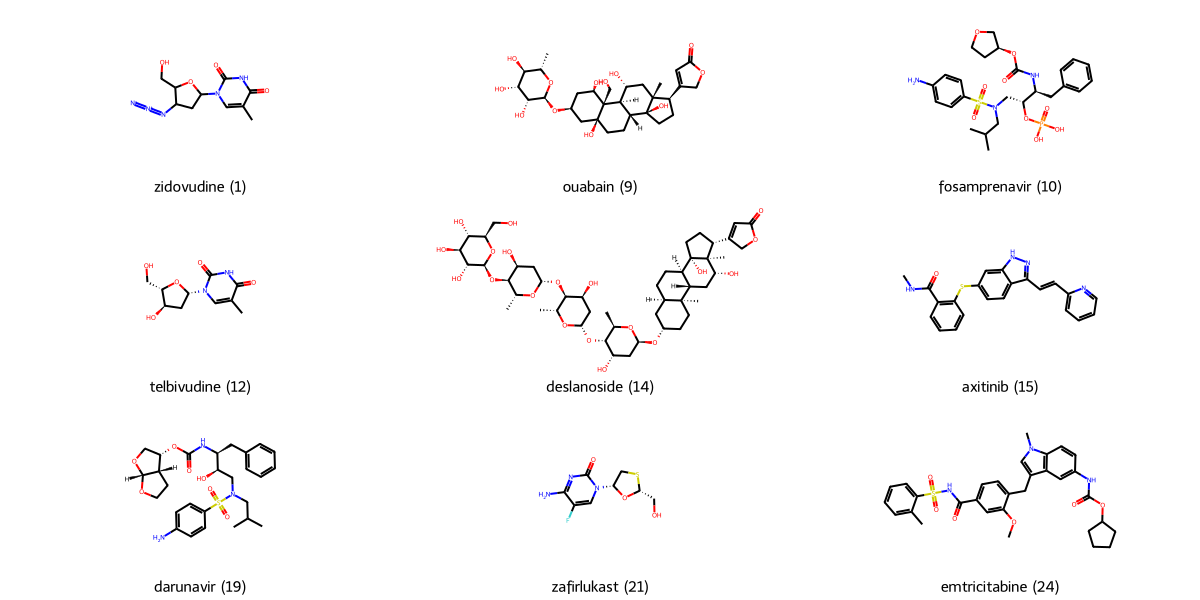

In [144]:
import cairosvg
smiles_list = [
        "CC1=CN(C(=O)NC1=O)C2CC(C(O2)CO)N=[N+]=[N-]", 
        "[H][C@@]12CC[C@]3(O)C[C@H](C[C@@H](O)[C@]3(CO)[C@@]1([H])[C@H](O)C[C@]1(C)[C@H](CC[C@]21O)C1=CC(=O)OC1)O[C@@H]1O[C@@H](C)[C@H](O)[C@@H](O)[C@H]1O",
        "CC(C)CN(C[C@H]([C@H](CC1=CC=CC=C1)NC(=O)O[C@H]2CCOC2)OP(=O)(O)O)S(=O)(=O)C3=CC=C(C=C3)N", 
        "CC1=CN([C@@H]2C[C@@H](O)[C@H](CO)O2)C(=O)NC1=O", 
        "C[C@H]1O[C@H](C[C@H](O)[C@@H]1O[C@H]1C[C@H](O)[C@H](O[C@H]2C[C@H](O)[C@H](O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@@H](C)O2)[C@@H](C)O1)O[C@H]1CC[C@@]2(C)[C@H](CC[C@@H]3[C@@H]2C[C@@H](O)[C@]2(C)[C@H](CC[C@]32O)C2=CC(=O)OC2)C1",
        "CNC(=O)C1=C(SC2=CC=C3C(NN=C3\C=C\C3=CC=CC=N3)=C2)C=CC=C1",
        "[H][C@@]12CCO[C@]1([H])OC[C@@H]2OC(=O)N[C@@H](CC1=CC=CC=C1)[C@H](O)CN(CC(C)C)S(=O)(=O)C1=CC=C(N)C=C1",
        "NC1=NC(=O)N(C=C1F)[C@@H]1CS[C@H](CO)O1",
        "COC1=CC(=CC=C1CC1=CN(C)C2=C1C=C(NC(=O)OC1CCCC1)C=C2)C(=O)NS(=O)(=O)C1=CC=CC=C1C"
]

names_list = [
        "zidovudine (1)",
        "ouabain (9)",
        "fosamprenavir (10)",
        "telbivudine (12)",
        "deslanoside (14)",
        "axitinib (15)",
        "darunavir (19)",
        "zafirlukast (21)",
        "emtricitabine (24)"]
    
        

mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]


for i in range(len(mol_list)):
    mol_list[i].SetProp("_Name", names_list[i])


img = Chem.Draw.MolsToGridImage(
        
        mol_list,
        legends=[mol.GetProp('_Name') for mol in mol_list],
        subImgSize=(400, 200),
        returnPNG=False)

img
#cairosvg.svg2pdf(bytestring=svg.encode('utf-8'), write_to="copt2.pdf")
#img.save("test.png", dpi=(1000, 1000))

In [115]:
print(a)

<IPython.core.display.Image object>
